# July ??, 2021

**Motivation**: Mouse meeting presentation. <br>


In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
svinet_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/svinet')


# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.network import Network
from analysis.helper import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE



def hierarchical_compare(
        hierarchical: dict,
        n_clusters: Union[range, list],
        key_fx: str = 'sub-SLC',
        keys_mv: List[str] = None,
        dist_measure: str = 'dice',
        cmap='RdYlBu_r',
        figsize=None, ):
    
    allen = hierarchical[key_fx].mice.allen
    contour = hierarchical[key_fx].mice.parcel.results2d['contour']
    
    keys_mv = keys_mv if keys_mv else ['ses-1', 'ses-2', 'ses-3']
    nrows, ncols = len(keys_mv) + 1, len(n_clusters)
    figsize = figsize if figsize else (13.5, 1.75 * nrows)
    fig, axes = create_figure(nrows, ncols, figsize=figsize)

    match_results = {}
    for j, n in tqdm(enumerate(n_clusters), total=len(n_clusters), leave=False):
        fx_masks = hierarchical[key_fx].results[n]['cluster_masks']
        _, x2d = masks2cluster(fx_masks, allen)
        
        cond = np.logical_or(contour, x2d == 0)
        _cond, _x = filter_boundaries([cond, x2d], mask=x2d.astype(bool))
        data2plt = np.ma.masked_where(_cond, _x)
        axes[0, j].imshow(data2plt, cmap=cmap)
        axes[0, j].set_title(f"n = {n}", fontsize=17, y=1.06)
        if j == 0:
            axes[0, j].set_ylabel(f"{key_fx}\n", fontsize=15)

        for i, key in enumerate(keys_mv):
            mv_masks = hierarchical[key].results[n]['cluster_masks']
            scores, mappings = clusters_sim_scores(fx_masks, mv_masks, weighted=True)
            match_results['_vs_'.join([key_fx, key])] = (scores, mappings)

            algn_idxs = list(mappings[dist_measure].values())
            mv_algn = dict(zip(
                list(mv_masks),
                np.array(list(mv_masks.values()))[algn_idxs]
            ))
            _, x2d_algn = masks2cluster(mv_algn, allen)

            cond = np.logical_or(contour, x2d_algn == 0)
            _cond, _x = filter_boundaries([cond, x2d_algn], mask=x2d_algn.astype(bool))
            data2plt = np.ma.masked_where(_cond, _x)
            axes[i + 1, j].imshow(data2plt, cmap=cmap)
            if j == 0:
                axes[i + 1, j].set_ylabel(f"{key}\n", fontsize=14)
    remove_ticks(axes)
    return fig, axes, match_results

### Report # voxels per ROI in the individual space
### Report estimated # neurons per ROI in individual space
### Add a checker that makes sure each ROI mask has at least one nonzero voxel

## SVINET

In [3]:
mice = Mice(Config(512))
mice.combine_dfs('rest')

key = 'sub-SLC'
metric = 'spearman'
mode = 'bold'
net = Network(
    mice=mice,
    key=key,
    metric=metric,
    mode=mode,
    binarize=False,
).fit()

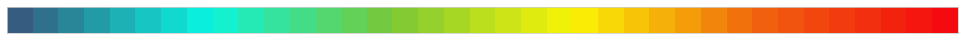

In [4]:
display_cmap(net.style['cmap'])

### Save Graphs

In [5]:
from analysis.network_helpers import save_edgelist, load_svinet

In [6]:
graphs = {}
for p in net.percentiles:
    graphs[f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_p-{p}"] = net.graphs[p]
    # graphs[f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_cfg_p-{p}"] = net.graphs_cfg[perc]

list(graphs)

[
    'bold_spearman_sub-SLC_n512_p-30',
    'bold_spearman_sub-SLC_n512_p-25',
    'bold_spearman_sub-SLC_n512_p-20',
    'bold_spearman_sub-SLC_n512_p-15',
    'bold_spearman_sub-SLC_n512_p-10'
]

In [8]:
for name, g in graphs.items():
    save_dir = pjoin(svinet_ws, name)
    os.makedirs(save_dir, exist_ok=True)
    save_edgelist(g, name=name, save_dir=save_dir)

### Load results

In [7]:
def get_filter_fn(num_comm, sampling=''):
    keywords = [f"k{num_comm}", sampling]
    def filter_fn(x):
        return all(k in x for k in keywords)
    return filter_fn

def _sort_fn(x):
    return next(
        int(e.replace('seed', '').strip())
        for e in x.split('-') if 'seed' in e
    )

In [8]:
perc = 30
expt_name = next(k for k in graphs if f"p-{perc}" in k)

num_comm = 7
sampling = 'linksampling'

In [9]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if name != expt_name:
        continue
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed95-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed137-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed159-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed161-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed200-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed208-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed212-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed220-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed233-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed280-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed377-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed384-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed390-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed424-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed435-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed479-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed492-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed595-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed607-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed654-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed665-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed694-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed699-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed768-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed790-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed820-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed828-linksampling, # communities: 6

Warning, name: bold_spearman_sub-SLC_n512_p-30
bad fit: n522-k7-mmsb-seed946-linksampling, # communities: 5

In [10]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n512_p-30': 972}

In [11]:
run = list(svinet_results[expt_name].values())[51]

community = {
    i + 1: [net.node_labels[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.node_labels[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [12]:
run['num_overlap']

719

In [13]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.node_labels), len(set(included_nodes)), num_overlap_nodes

(522, 521, 719)

In [14]:
[region for i, region in net.node_labels.items() if i not in set(included_nodes)]

['1-315-468']

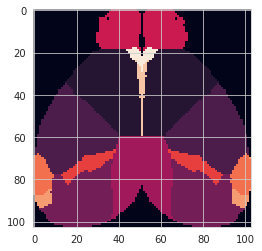

In [15]:
plt.imshow(filter_boundaries(mice.parcel.results2d['atlas']));

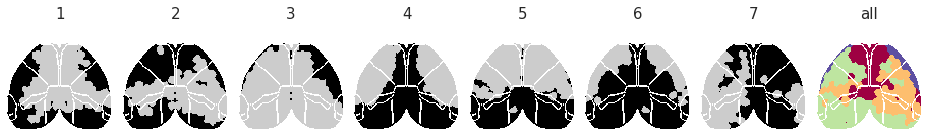

In [16]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

fig, axes = create_figure(1, num_comm + 1, (13, 3))

x2d_full = masks2cluster(masks_isocortex, mice.allen)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap='Spectral')
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2cluster({i: masks_isocortex[i]}, mice.allen)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    ax.imshow(data2plt, cmap='nipy_spectral')
    ax.set_title(i, fontsize=15)

remove_ticks(axes)
plt.show()

### Align using memship vectors

In [17]:
prototypes = []
for run in svinet_results[expt_name].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [18]:
prototypes.shape

(6804, 522)

<matplotlib.colorbar.Colorbar object at 0x7f1d795bda60>

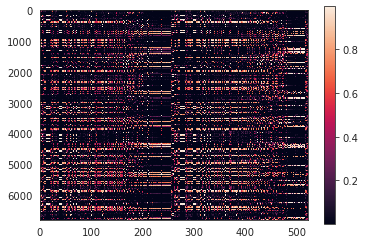

In [19]:
plt.imshow(prototypes, aspect=0.06)
plt.colorbar()

In [20]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [21]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

In [22]:
delta

'00 - 00:00:00  (dd - hh:mm:ss)\n'

In [23]:
model.cluster_centers_.shape

(7, 522)

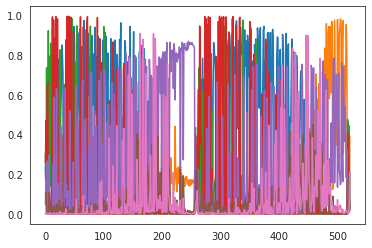

In [24]:
plt.plot(model.cluster_centers_.T);

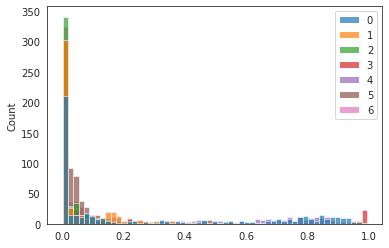

In [25]:
sns.histplot(model.cluster_centers_.T, alpha=0.7);

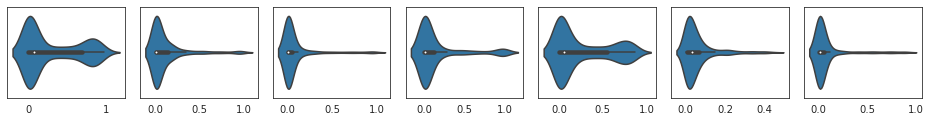

In [26]:
fig, axes = create_figure(1, num_comm, (13, 1.8))

for i in range(num_comm):
    sns.violinplot(model.cluster_centers_[i], ax=axes[i])
plt.show()

In [27]:
memship_vec_can = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.node_labels.items()
    } for i in range(num_comm)
}
memship_vol_can = vec2vol(memship_vec_can, mice)
memship_vol_can.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

In [28]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in tqdm(qs):
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol_can.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f1d4404d160>

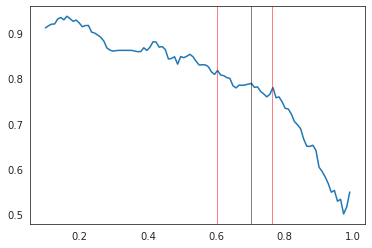

In [38]:
plt.plot(qs, sym_scores)
plt.axvline(0.603, color='r', lw=0.5)
plt.axvline(0.70, color='k', lw=0.5)
plt.axvline(0.764, color='r', lw=0.5)

In [39]:
q = 0.603
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}

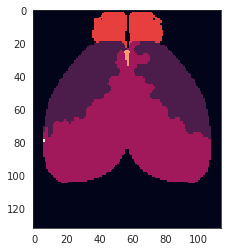

In [41]:
x3d, x2d = masks2cluster(comms_quant, mice.allen)
plt.imshow(x2d);


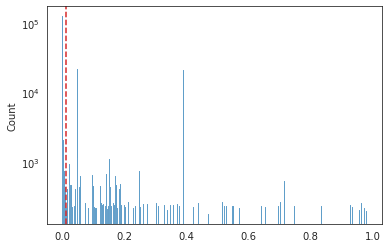

In [42]:
v = memship_vol_can[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')
plt.yscale('log')

In [43]:
q = 0.603
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

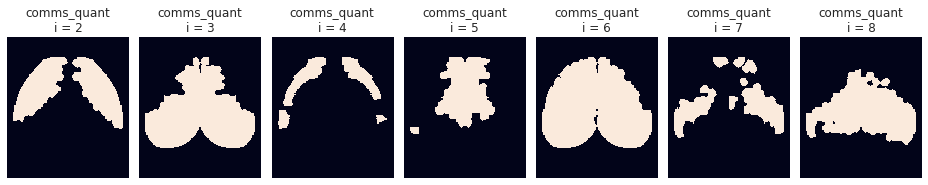

In [44]:
fig, axes = create_figure(1, num_comm, (13, 3.5))

for ii in range(1, num_comm + 1):
    x2d = masks2cluster({ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])}, mice.allen)[-1]
    axes[ii - 1].imshow(x2d)
    axes[ii - 1].set_title(f"comms_quant\ni = {ii+1}")
    
remove_ticks(axes)

In [45]:
centers = dc(model.cluster_centers_)
metrics = [
    'cosine',
    'correlation',
    'braycurtis',
    'jensenshannon',
]
dict_list = []
perms = {}
for run_name, run in svinet_results[expt_name].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(float),
            XB=run['pi'].astype(float),
            metric=metric,
        ) for metric in metrics
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

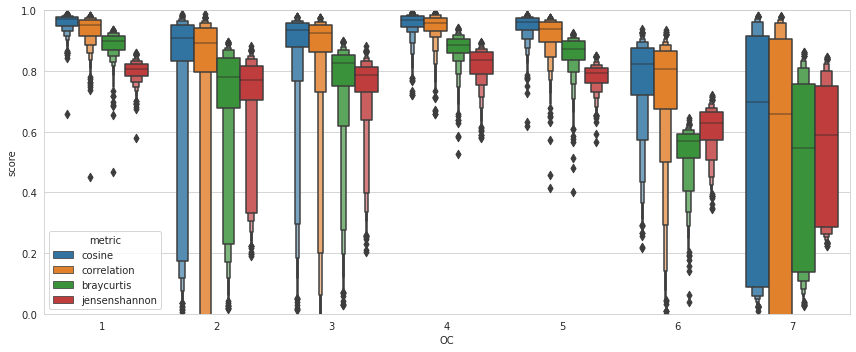

In [47]:
fig, ax = create_figure(1, 1, (12, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)
plt.show()

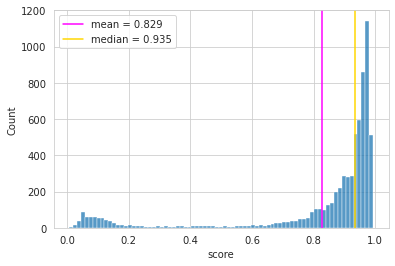

In [50]:
selected_df = results.loc[results.metric.isin(['cosine'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [51]:
oc_aligned = {}
for run_name, run in svinet_results[expt_name].items():
    comm_vec = {
        i + 1: np.reshape([1 if i in v else 0 for i in net.node_labels], (1, -1))
        for i, v in run['community_sv'].items()
    }
    oc_moving = np.concatenate(list(comm_vec.values()))

    mapping = perms[run_name]
    oc_aligned[run_name] = oc_moving[list(mapping.values())]

In [52]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [53]:
oc_flat_df.shape

(3551688, 5)

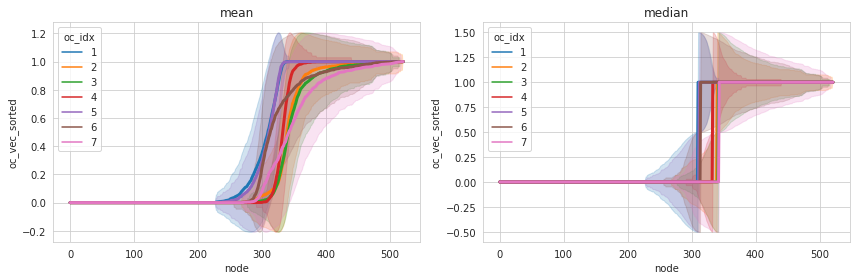

In [54]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=3,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
plt.show()

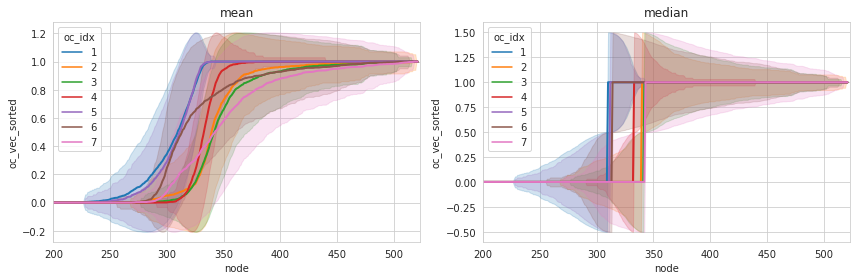

In [55]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(200, len(net.node_labels) + 1)
plt.show()

In [56]:
pi_aligned = {}
for run_name, run in svinet_results[expt_name].items():
    mapping = perms[run_name]
    pi = run['pi'][list(mapping.values())]
    pi_aligned[run_name] = np.round(pi, 1)

In [57]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'pi_vec': pi_aligned[run_name][i],
            'pi_vec_sorted': sorted(pi_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

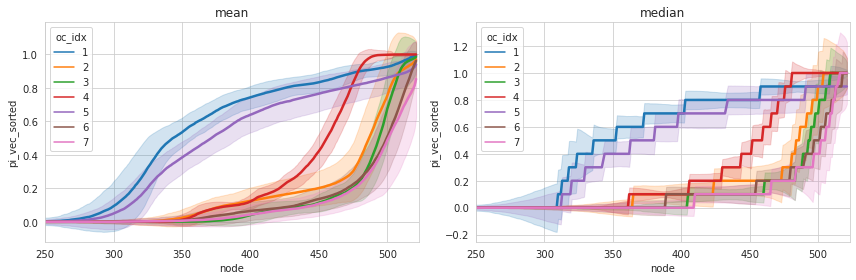

In [58]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=2.5,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(250, len(net.node_labels) + 1)
plt.show()

In [59]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 10:
        break
    mapping = perms[run_name]       
    community = {
        i + 1: [net.node_labels[e] for e in comm_list]
        for i, comm_list in run['community_sv'].items()
    }
    community = dict(zip(
        community.keys(),
        np.array(list(community.values()))[list(mapping.values())]
    ))
    masks = community2masks(community, mice)
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in masks.items()
    }
    masks_aligned[run_name] = masks_cortex

In [60]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2cluster(comms_quant, mice.allen)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

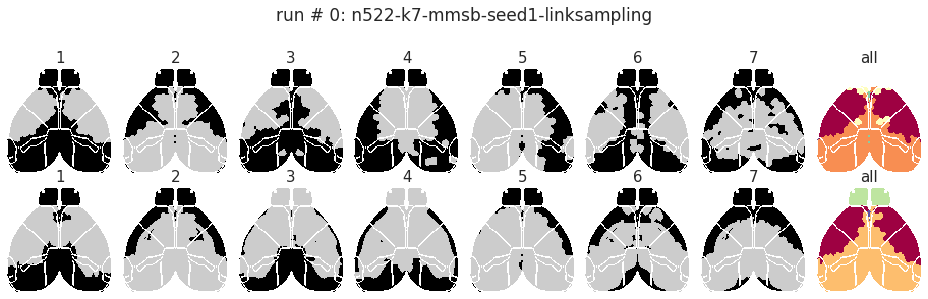

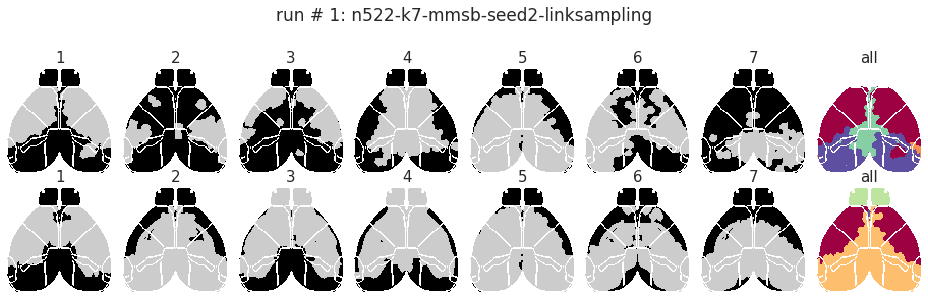

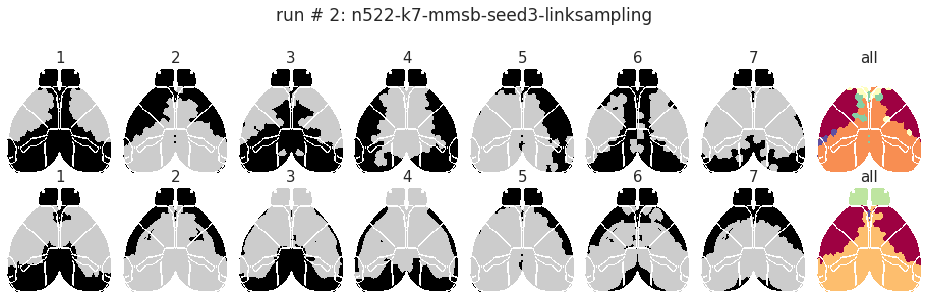

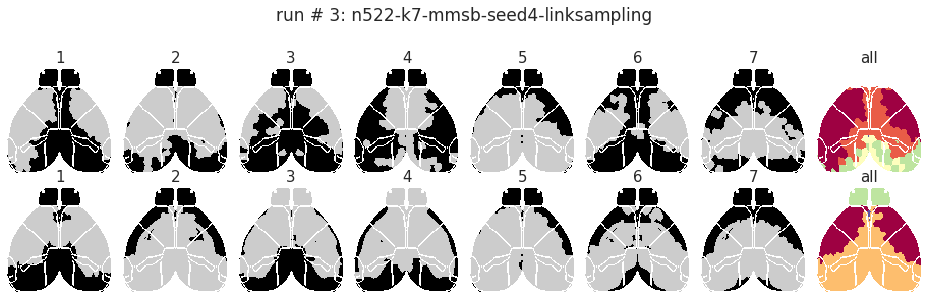

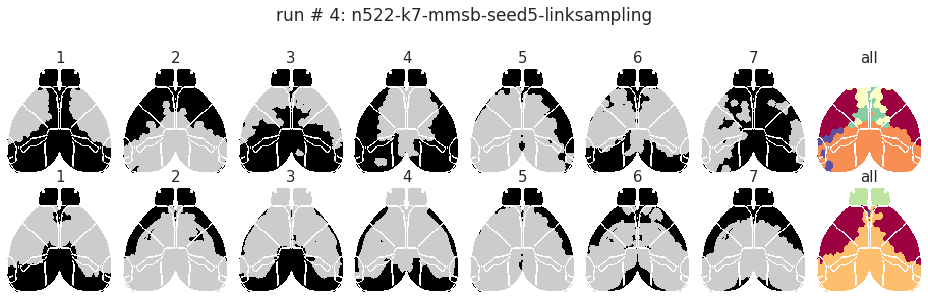

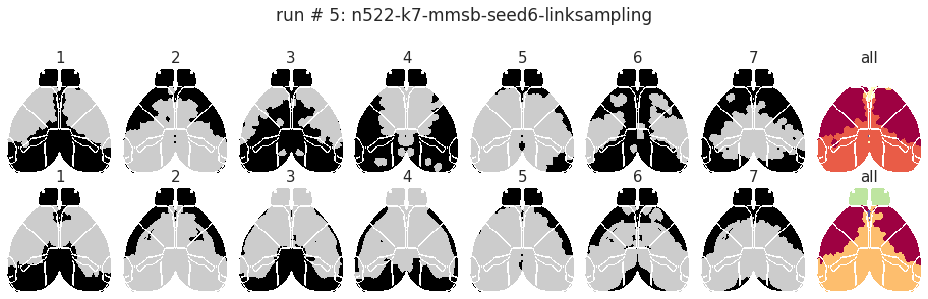

In [61]:
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 5:
        break
    
    fig, axes = create_figure(2, num_comm + 1, (13, 4))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: masks_aligned[run_name][i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

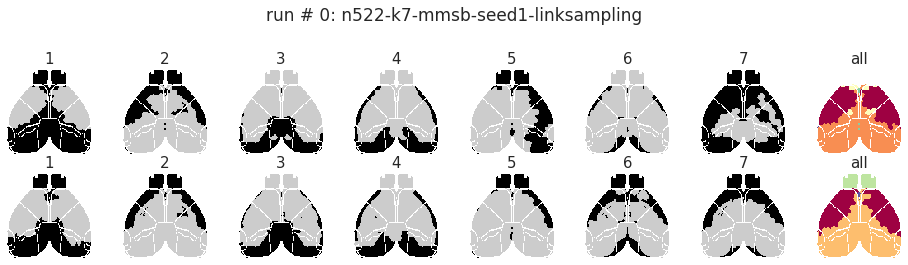

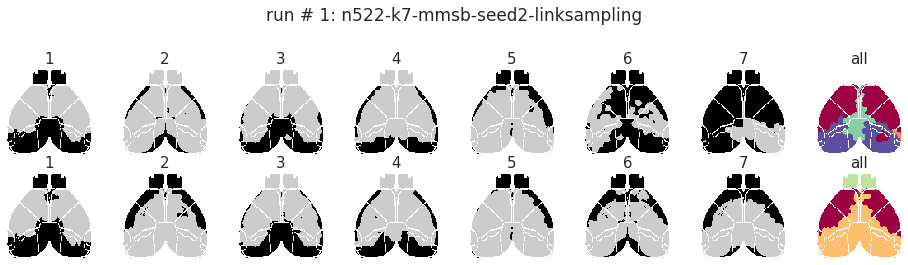

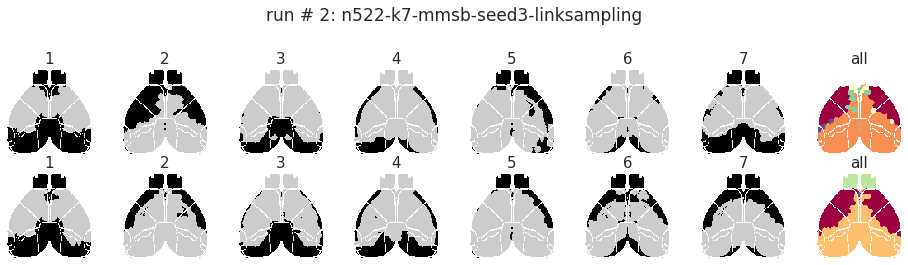

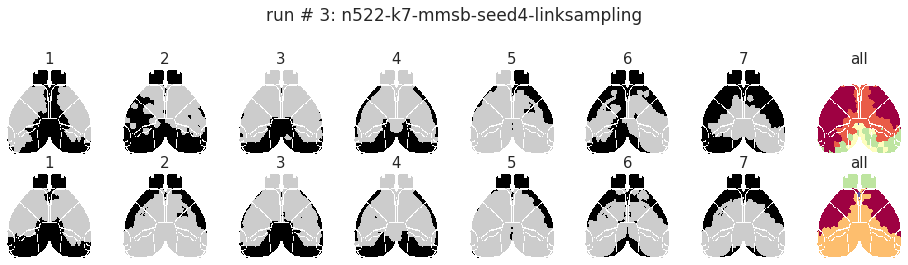

In [62]:
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 3:
        break

    memship_vecs = {
        i + 1: {
            region: pi_aligned[run_name][i, n]
            for n, region in net.node_labels.items()
        } for i in range(num_comm)
    }
    memship_vols = vec2vol(memship_vecs, mice)
    
    fig, axes = create_figure(2, num_comm + 1, (13, 3.5))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: memship_vols[i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

In [63]:
pi_aligned = {}
for run_name, run in svinet_results[expt_name].items():
    mapping = perms[run_name]
    pi = run['pi'][list(mapping.values())]
    pi_aligned[run_name] = np.round(pi, 1)

In [64]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [65]:
dict_list = []
for run_name in tqdm(svinet_results[expt_name]):
    for i in range(num_comm):
        mem = pi_aligned[run_name][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()       
        
        counts = mem_cut.values.tolist()
        if not sum(counts):
            print('vay dada: ', run_name, i)
            continue
        
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/972 [00:00<?, ?it/s]

vay dada:  n522-k7-mmsb-seed81-linksampling 1

vay dada:  n522-k7-mmsb-seed270-linksampling 2

vay dada:  n522-k7-mmsb-seed378-linksampling 6

vay dada:  n522-k7-mmsb-seed455-linksampling 6

vay dada:  n522-k7-mmsb-seed613-linksampling 6

vay dada:  n522-k7-mmsb-seed797-linksampling 6

vay dada:  n522-k7-mmsb-seed815-linksampling 6

vay dada:  n522-k7-mmsb-seed823-linksampling 1

vay dada:  n522-k7-mmsb-seed942-linksampling 5

...merging dicts: 0it [00:00, ?it/s]

In [66]:
pi_cut_df.shape

(67950, 5)

In [67]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

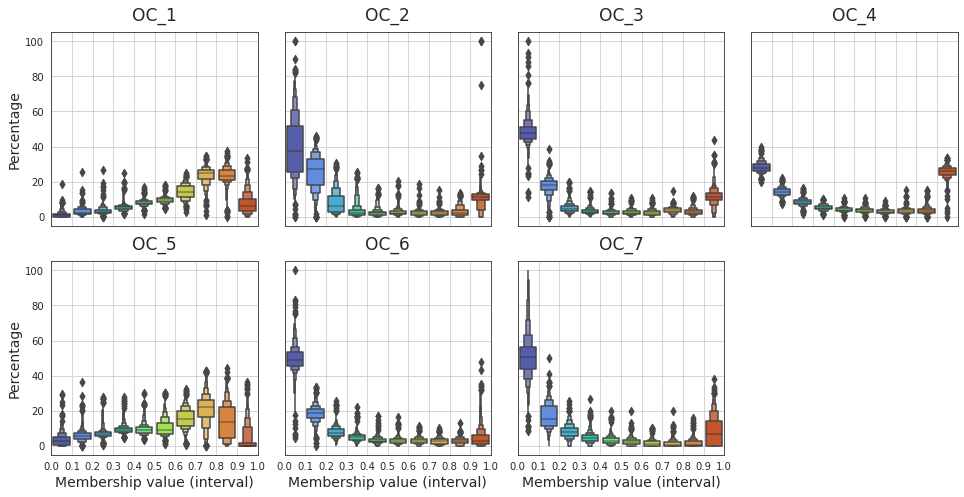

In [68]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 7), 'white', 'all', 'all')

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

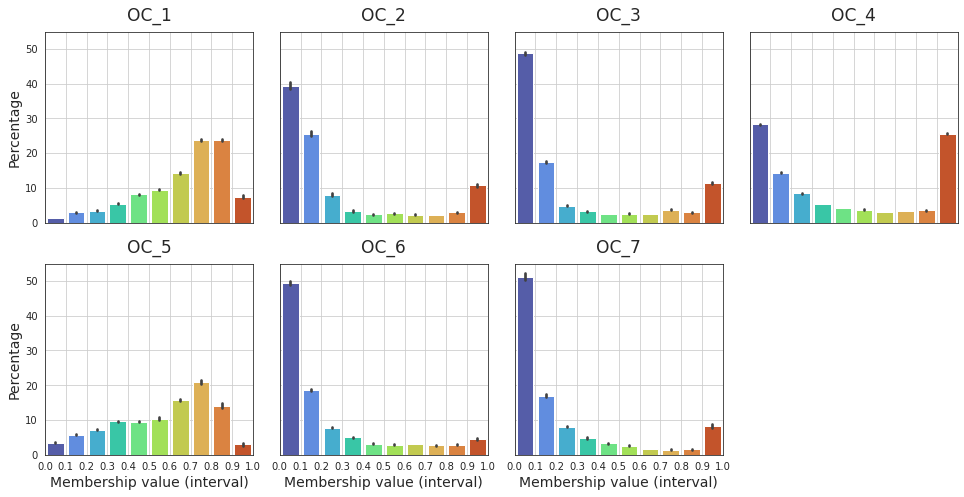

In [69]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 7), 'white', 'all', 'all')

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [71]:
q = 0.603
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [78]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#edf53d',
    '#f53d91', '#3df5f1', '#f5603d',
    '#92f53d', '#3d46f5', '#f53def',
    '#f5a37a', 
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

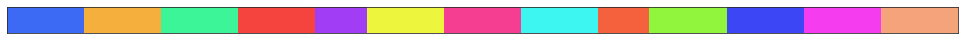

In [79]:
oc_cmap = make_cmap(
    list(colors_fancy.values()),
    n_colors=len(colors_fancy),
    name='OC',
)

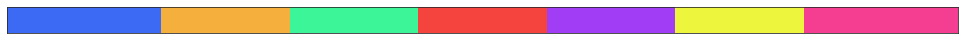

In [80]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

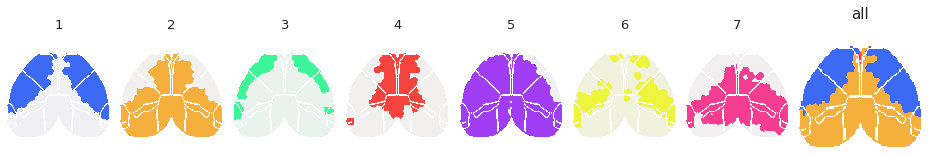

In [82]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2cluster(masks_cortex, mice.allen)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2cluster({i: masks_cortex[i]}, mice.allen)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [83]:
import ants
template = ants.from_numpy(mice.allen['template'].astype(float))

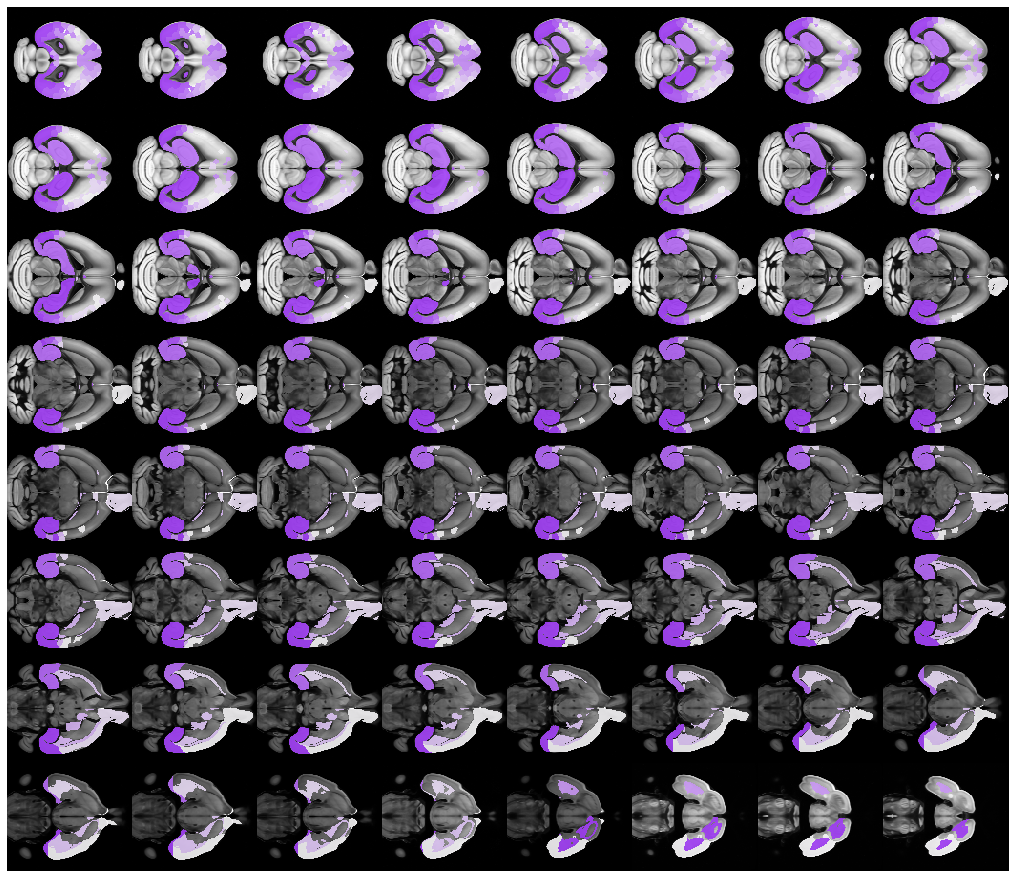

In [86]:
i = 5
img = ants.from_numpy(memship_vols[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [89]:
# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [90]:
_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_p-{perc}",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_p-30_parcel-7_cmap-OC.html

## Sparse (perc=10)

In [150]:
perc = 10
expt_name = next(k for k in graphs if f"p-{perc}" in k)

num_comm = 7
sampling = 'linksampling'

In [151]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if name != expt_name:
        continue
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [152]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n512_p-10': 1000}

In [153]:
run = list(svinet_results[expt_name].values())[51]

community = {
    i + 1: [net.node_labels[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.node_labels[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [155]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.node_labels), len(set(included_nodes)), num_overlap_nodes

(522, 519, 351)

In [156]:
[region for i, region in net.node_labels.items() if i not in set(included_nodes)]

['0-315-45', '0-315-122', '0-315-158']

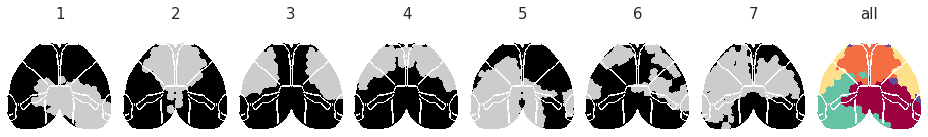

In [158]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

fig, axes = create_figure(1, num_comm + 1, (13, 3))

x2d_full = masks2cluster(masks_isocortex, mice.allen)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap='Spectral')
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2cluster({i: masks_isocortex[i]}, mice.allen)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    ax.imshow(data2plt, cmap='nipy_spectral')
    ax.set_title(i, fontsize=15)

remove_ticks(axes)
plt.show()

### Align using memship vectors

In [159]:
prototypes = []
for run in svinet_results[expt_name].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [160]:
prototypes.shape

(7000, 522)

<matplotlib.colorbar.Colorbar object at 0x7f05ce4bd5b0>

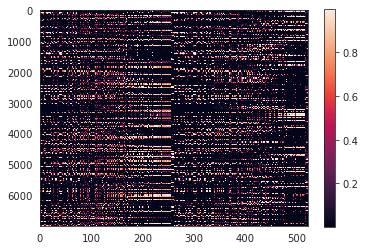

In [161]:
plt.imshow(prototypes, aspect=0.06)
plt.colorbar()

In [162]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [163]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

In [164]:
delta

'00 - 00:00:01  (dd - hh:mm:ss)\n'

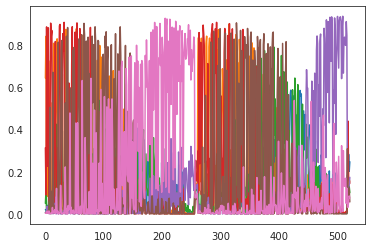

In [166]:
plt.plot(model.cluster_centers_.T);

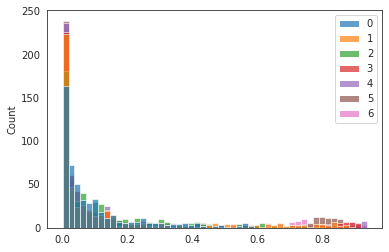

In [167]:
sns.histplot(model.cluster_centers_.T, alpha=0.7);

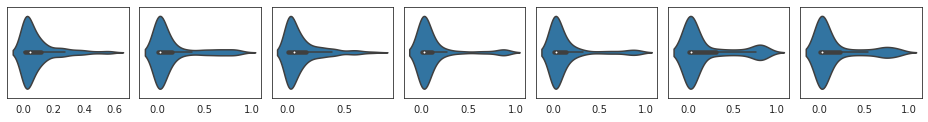

In [169]:
fig, axes = create_figure(1, num_comm, (13, 1.8))

for i in range(num_comm):
    sns.violinplot(x=model.cluster_centers_[i], ax=axes[i])
plt.show()

In [170]:
memship_vec_can = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.node_labels.items()
    } for i in range(num_comm)
}
memship_vol_can = vec2vol(memship_vec_can, mice)
memship_vol_can.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

In [171]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in tqdm(qs):
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol_can.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f066c721e80>

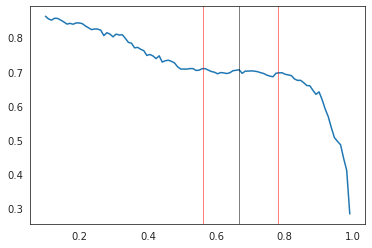

In [181]:
plt.plot(qs, sym_scores)
plt.axvline(0.56, color='r', lw=0.5)
plt.axvline(0.666, color='k', lw=0.5)
plt.axvline(0.78, color='r', lw=0.5)

In [182]:
q = 0.666
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}

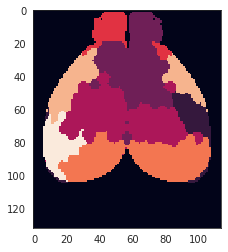

In [193]:
x3d, x2d = masks2cluster(comms_quant, mice.allen)
plt.imshow(x2d);


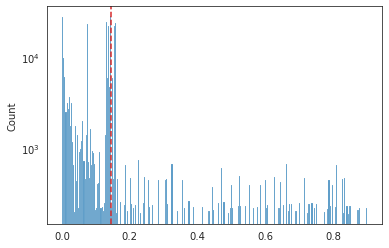

In [194]:
v = memship_vol_can[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')
plt.yscale('log')

In [195]:
q = 0.666
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.node_labels.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

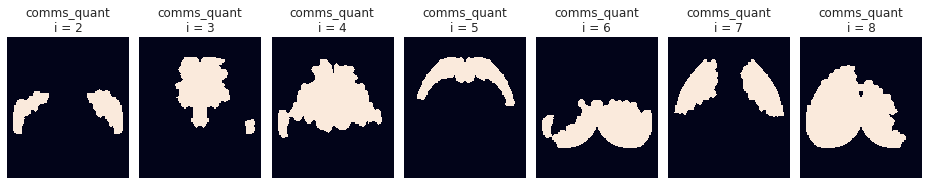

In [196]:
fig, axes = create_figure(1, num_comm, (13, 3.5))

for ii in range(1, num_comm + 1):
    x2d = masks2cluster({ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])}, mice.allen)[-1]
    axes[ii - 1].imshow(x2d)
    axes[ii - 1].set_title(f"comms_quant\ni = {ii+1}")
    
remove_ticks(axes)

In [197]:
centers = dc(model.cluster_centers_)
metrics = [
    'cosine',
    'correlation',
    'braycurtis',
    'jensenshannon',
]
dict_list = []
perms = {}
for run_name, run in svinet_results[expt_name].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(float),
            XB=run['pi'].astype(float),
            metric=metric,
        ) for metric in metrics
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

(0.0, 1.0)

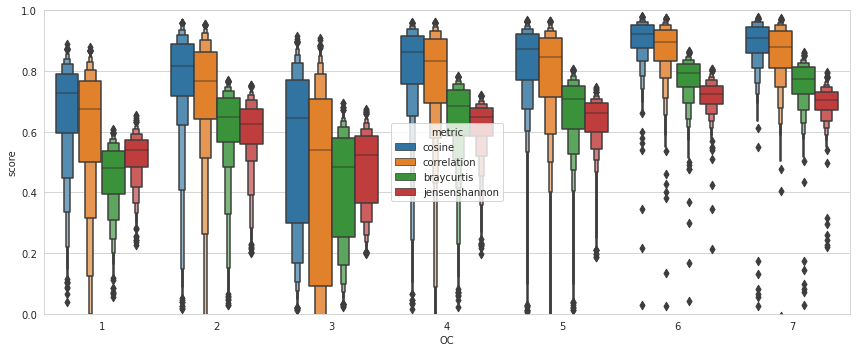

In [198]:
fig, ax = create_figure(1, 1, (12, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)

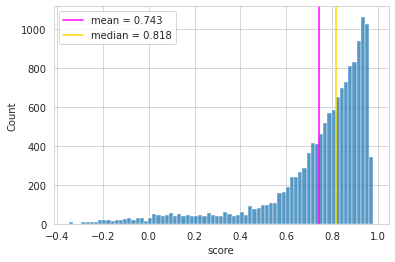

In [199]:
selected_df = results.loc[results.metric.isin(['cosine', 'correlation'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [200]:
oc_aligned = {}
for run_name, run in svinet_results[expt_name].items():
    comm_vec = {
        i + 1: np.reshape([1 if i in v else 0 for i in net.node_labels], (1, -1))
        for i, v in run['community_sv'].items()
    }
    oc_moving = np.concatenate(list(comm_vec.values()))

    mapping = perms[run_name]
    oc_aligned[run_name] = oc_moving[list(mapping.values())]

In [201]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [202]:
oc_flat_df.shape

(3654000, 5)

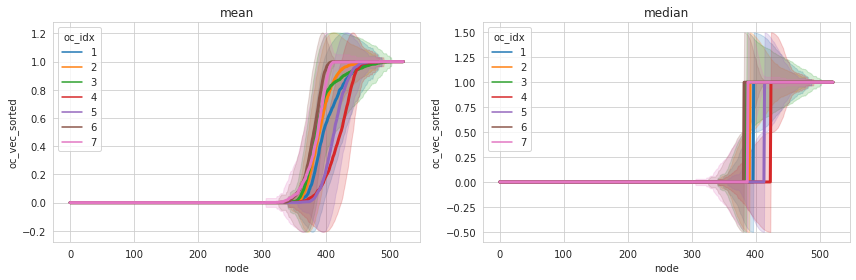

In [203]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=3,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
plt.show()

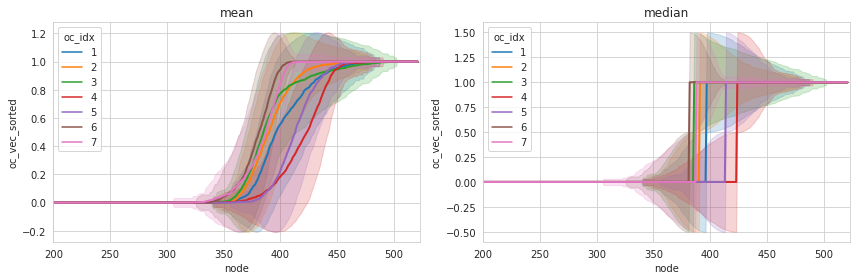

In [204]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(200, len(net.node_labels) + 1)
plt.show()

In [205]:
pi_aligned = {}
for run_name, run in svinet_results[expt_name].items():
    mapping = perms[run_name]
    pi = run['pi'][list(mapping.values())]
    pi_aligned[run_name] = np.round(pi, 1)

In [206]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.node_labels,
            'run': [run_name] * len(net.node_labels),
            'oc_idx': [i + 1] * len(net.node_labels),
            'pi_vec': pi_aligned[run_name][i],
            'pi_vec_sorted': sorted(pi_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

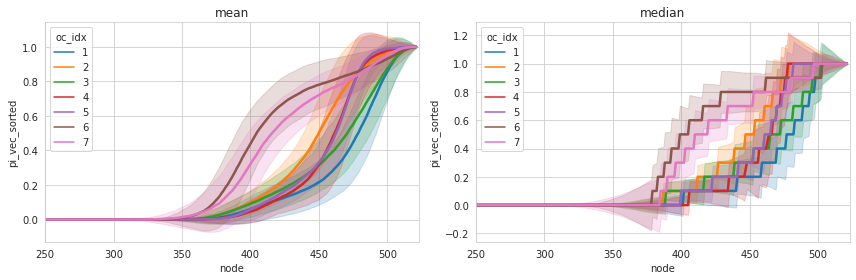

In [207]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=2.5,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(250, len(net.node_labels) + 1)
plt.show()

In [208]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 10:
        break
    mapping = perms[run_name]       
    community = {
        i + 1: [net.node_labels[e] for e in comm_list]
        for i, comm_list in run['community_sv'].items()
    }
    community = dict(zip(
        community.keys(),
        np.array(list(community.values()))[list(mapping.values())]
    ))
    masks = community2masks(community, mice)
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in masks.items()
    }
    masks_aligned[run_name] = masks_cortex

<ipython-input-208-a81edf1d73a6>:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [209]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2cluster(comms_quant, mice.allen)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

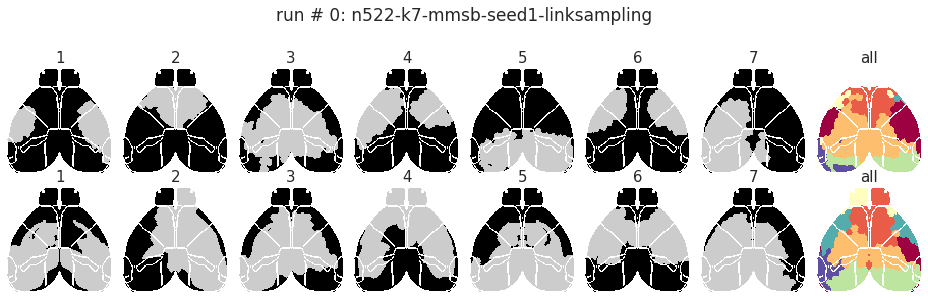

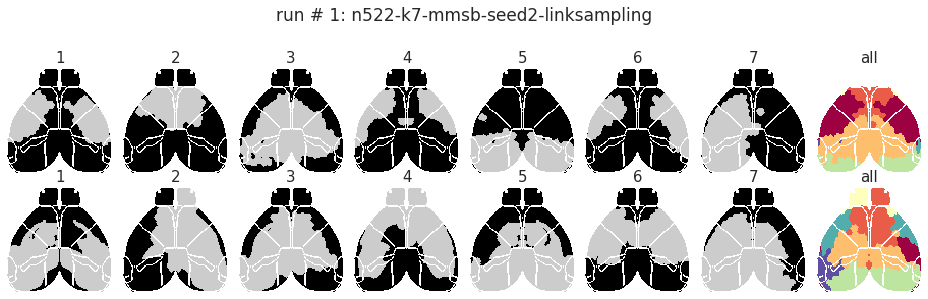

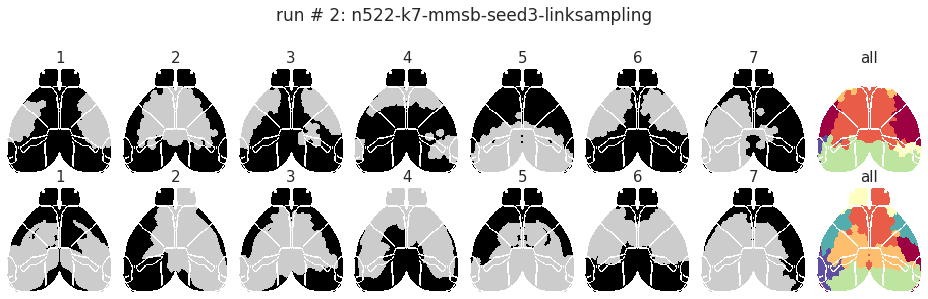

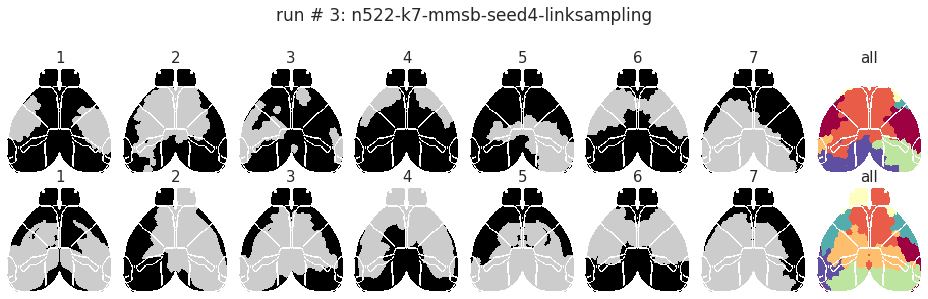

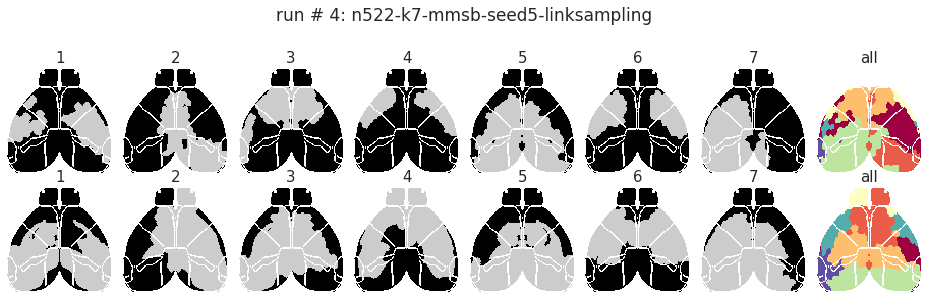

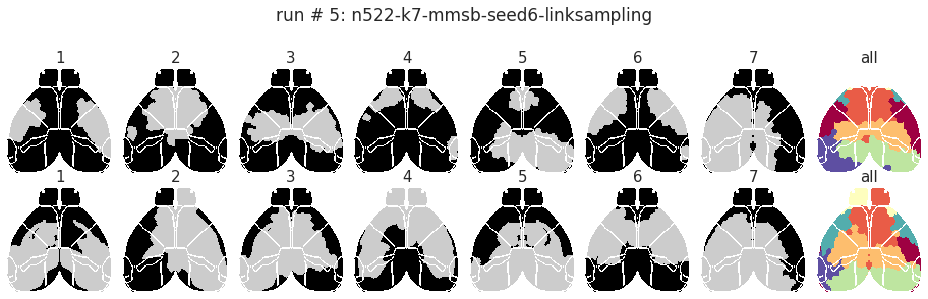

In [210]:
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 5:
        break
    
    fig, axes = create_figure(2, num_comm + 1, (13, 4))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: masks_aligned[run_name][i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

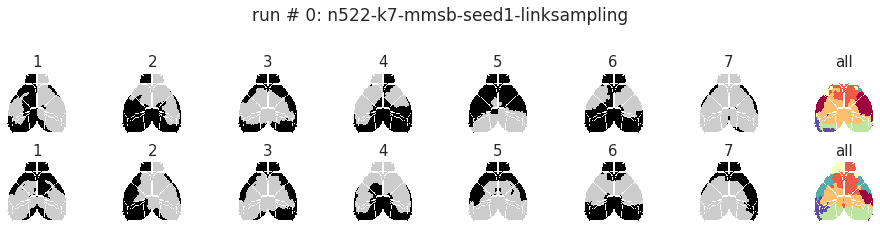

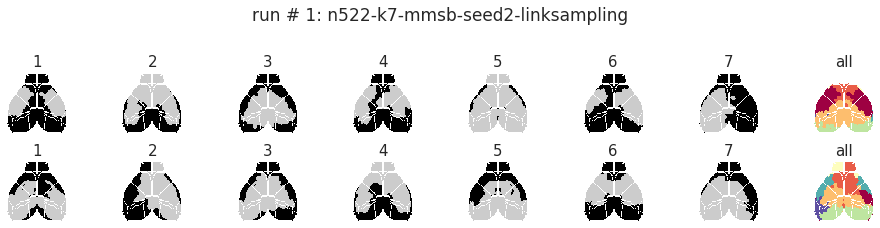

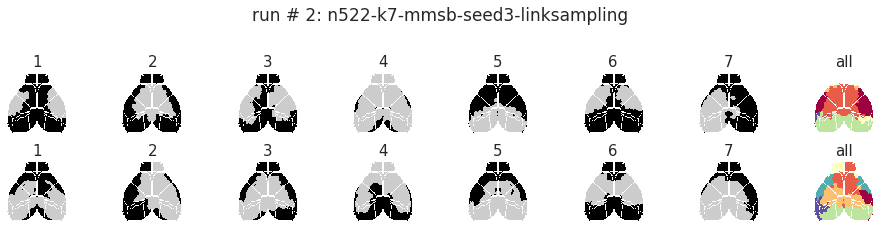

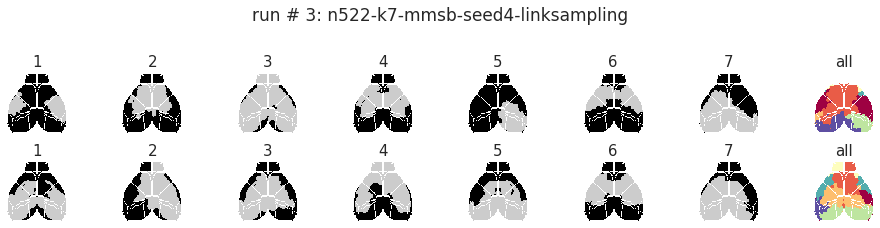

In [211]:
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 3:
        break

    memship_vecs = {
        i + 1: {
            region: pi_aligned[run_name][i, n]
            for n, region in net.node_labels.items()
        } for i in range(num_comm)
    }
    memship_vols = vec2vol(memship_vecs, mice)
    
    fig, axes = create_figure(2, num_comm + 1, (13, 3))

    x2d_full = masks2cluster(masks_aligned[run_name], mice.allen)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2cluster({i: memship_vols[i]}, mice.allen)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2cluster({i: comms_quant[i]}, mice.allen)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

In [212]:
pi_aligned = {}
for run_name, run in svinet_results[expt_name].items():
    mapping = perms[run_name]
    pi = run['pi'][list(mapping.values())]
    pi_aligned[run_name] = np.round(pi, 1)

In [213]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [214]:
dict_list = []
for run_name in tqdm(svinet_results[expt_name]):
    for i in range(num_comm):
        mem = pi_aligned[run_name][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()       
        
        counts = mem_cut.values.tolist()
        if not sum(counts):
            print('vay dada: ', run_name, i)
            continue
        
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [215]:
pi_cut_df.shape

(70000, 5)

In [216]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

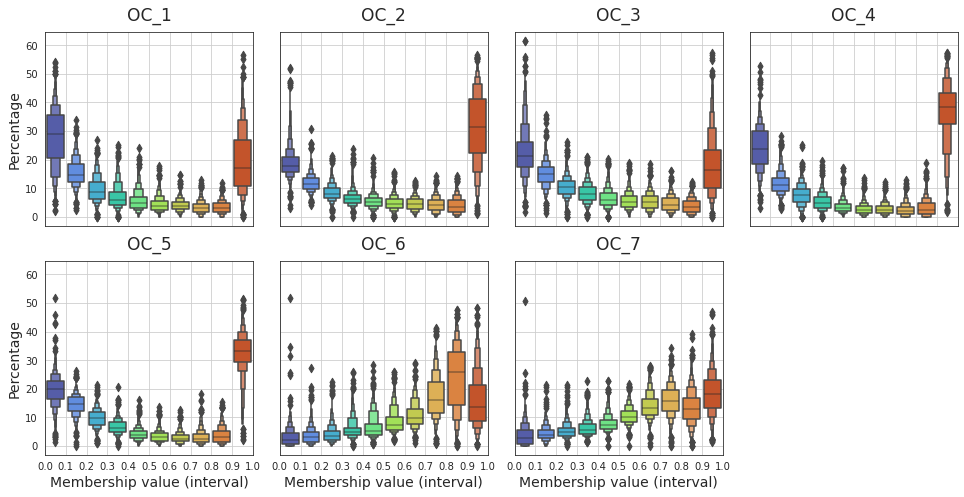

In [217]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 7), 'white', 'all', 'all')

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

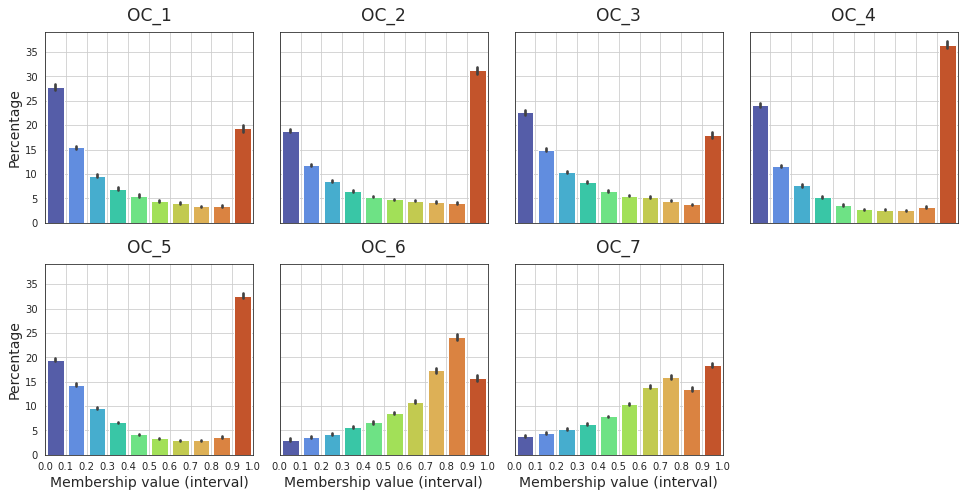

In [218]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 7), 'white', 'all', 'all')

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [219]:
q = 0.666
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol_can.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [220]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#edf53d',
    '#f53d91', '#3df5f1', '#f5603d',
    '#92f53d', '#3d46f5', '#f53def',
    '#f5a37a', 
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

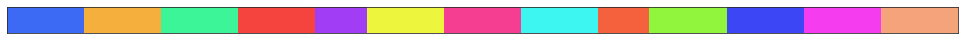

In [221]:
oc_cmap = make_cmap(
    list(colors_fancy.values()),
    n_colors=len(colors_fancy),
    name='OC',
)

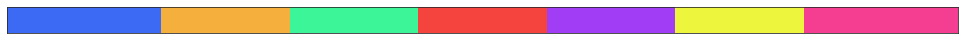

In [222]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

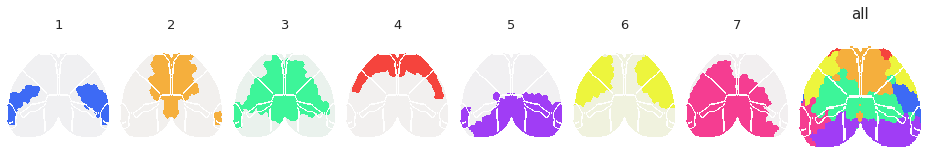

In [223]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2cluster(masks_cortex, mice.allen)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap=oc_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2cluster({i: masks_cortex[i]}, mice.allen)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [224]:
import ants
template = ants.from_numpy(mice.allen['template'].astype(float))

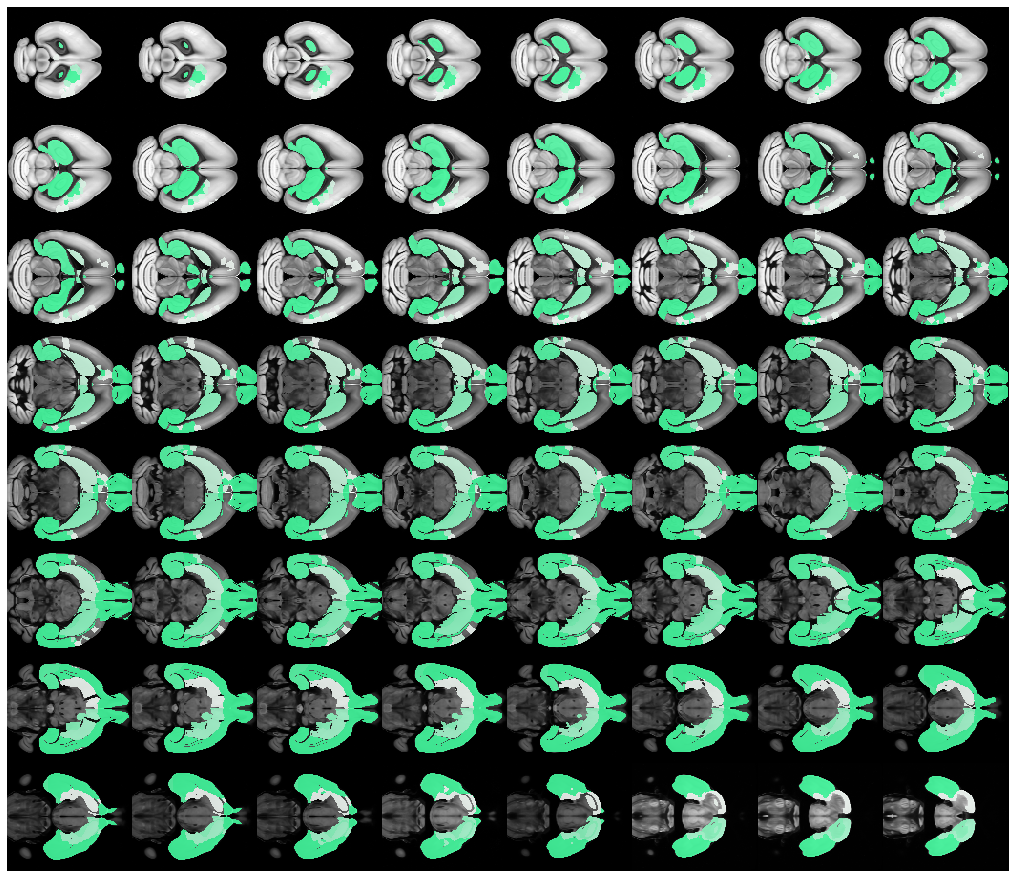

In [229]:
i = 3
img = ants.from_numpy(memship_vols[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [148]:
# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [226]:
_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name='SVINET_p-10',
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

/home/hadi/Dropbox/git/vedo/vedo/volume.py:967: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/hadi/anaconda3/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:66: DeprecationWarning:

Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.

/home/hadi/anaconda3/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:68: DeprecationWarning:

Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_p-10_parcel-7_cmap-OC.html